# Data Augemntation - Image Manipulation 
1. Geometric Transformations (Rotations, Translation, Shearing, Flipping)
2. Non- Geometric Transformations (Cropping, Noise injection, Color Space, Jitter, Kernel)

In [1]:
import torch
import shutil
import torchvision
from torchvision import models,datasets,transforms
import os
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random
import albumentations as A #this supposedly is much faster than using torchvision
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from sklearn.decomposition import PCA
from glob import glob

C:\Users\vidia\AppData\Roaming\Python\Python312\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.3'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
#create augmentation pipeline
#all of these need to be tuned for now these are some safe choices

augmentation_pipeline = A.Compose([
    # Geometric Transformations
    A.Rotate(limit=25, p=0.5),  # rotation +-25 with prob 0.5
    A.ShiftScaleRotate(shift_limit=0.3, scale_limit=0.2, rotate_limit=0, p=0.3),  # translation (shift and scale but do not rotate more)
    A.Affine(shear=5, p=0.5),  # shearing up to 5deg - does not seem that useful for us
    A.HorizontalFlip(p=0.5),  # flipping h

    # Non-Geometric Transformations
    A.RandomResizedCrop(size=[524,524], scale=(0.7, 1.0), p=0.5),  # gets randomly 70-100% of image and resized it back to 256x256
    A.GaussNoise(var_limit=(2, 10), p=0.2),  # less variance
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.2), # contrast for color (insetad of b&w)
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05, p=0.3),  # Color Adjustments different lightning conditions
    A.GaussianBlur(blur_limit=(3, 7), p=0.2),  # Kernel Blurring

    A.Resize(524, 524),  # resizing to 524x524 (then using tensor pipeline will be 256x256)

    ToTensorV2() #this computes it back to tensor - to use for pytorch
])

# F1 SCORES FOR TRASHNET Cardboard : 0.52 , Glass : 0.57, Metal : 0.62, Paper : 0.66, Plastic : 0.32, Trash : 0.05

C:\Users\vidia\AppData\Roaming\Python\Python312\site-packages\albumentations\core\validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\vidia\AppData\Local\Temp\ipykernel_38916\813644656.py:13: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(2, 10), p=0.2),  # less variance


In [4]:
# use the pipeline to also balance the dataset
# idea : augment images until limit set as majority_class*2

# if you want to test for yourself then update directories to "../example_data/dataset_balanced/train"
output_dir = "../data/dataset_balanced/train"


# define the paths
input_dir = "../data/dataset_split/train"  
output_dir = "../data/dataset_balanced/train"  # for balanced augmented dataset

# overwrite it
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)  # delete contents

os.makedirs(output_dir, exist_ok=True)

class_counts = {}
for class_folder in os.listdir(input_dir):
    class_path = os.path.join(input_dir, class_folder)
    num_images = len(os.listdir(class_path))
    class_counts[class_folder] = num_images

# change this
change_factor = 2

# Find the largest class (majority class)
max_class_size = max(class_counts.values())
new_target_size = max_class_size * change_factor

print(class_counts)
print(f"max category is {max_class_size} of class {max(class_counts, key=class_counts.get)}") 

for class_folder, current_count in tqdm(class_counts.items(), desc="Balancing & Expanding Classes"):
    class_path = os.path.join(input_dir, class_folder)
    augmented_class_path = os.path.join(output_dir, class_folder) #augmented images will be saved here
    os.makedirs(augmented_class_path, exist_ok=True)

    images = os.listdir(class_path)
    
    # decide later but this will copy all the non-augmented images as well 
    for img_name in images:
        src_path = os.path.join(class_path, img_name)
        dst_path = os.path.join(augmented_class_path, img_name)
        cv2.imwrite(dst_path, cv2.imread(src_path))  # Copy image

    # Compute number of extra images needed
    num_needed = new_target_size - current_count  # balancing all classes to 2*majority

    # Augment existing images
    while num_needed > 0:
        for img_name in images:
            if num_needed <= 0:
                break 

            img_path = os.path.join(class_path, img_name)
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV) to RGB

            augmented = augmentation_pipeline(image=image)["image"]  # Albumentations output

            # Save Augmented Image (Directly as PNG)
            output_filename = f"{os.path.splitext(img_name)[0]}_aug_{num_needed}.png"
            output_path = os.path.join(augmented_class_path, output_filename)

            # Ensure the output is a NumPy array before saving
            if isinstance(augmented, torch.Tensor):  
                augmented = augmented.permute(1, 2, 0).cpu().numpy()  # Convert CHW -> HWC
                augmented = (augmented * 255).astype(np.uint8)  # Convert from [0,1] to [0,255]

            # Save the augmented image
            cv2.imwrite(output_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))
            num_needed -= 1

print(f"✅ Dataset balanced & expanded! New images saved in {output_dir}")

{'cardboard': 368, 'glass': 336, 'metal': 632, 'paper': 400, 'plastic': 736, 'trash': 396}
max category is 736 of class plastic


Balancing & Expanding Classes: 100%|██████████| 6/6 [01:48<00:00, 18.06s/it]

✅ Dataset balanced & expanded! New images saved in ../data/dataset_balanced/train


In [8]:
#sos remember to change the directory for the tensors
dir = '../data/dataset_balanced'

params = { 'batch_size':16,
           'shuffle':True,
           'num_workers':4 }


transform = transforms.Compose([transforms.Resize(256),
                                transforms.RandomResizedCrop(256), #Augmented
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

#the training dataset will be from the datase_balanced folder 
train_dataset = datasets.ImageFolder(os.path.join(dir, 'train'),transform = transform )

transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(256),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


#change the dir for validationa (and test)
dir = '../data/dataset_split'
val_dataset = datasets.ImageFolder(os.path.join(dir, 'val'),transform = transform )


#data loaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, **params)
val_dataloader = torch.utils.data.DataLoader(val_dataset, **params)

class_names = train_dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Feature Analysis per class

In [9]:
# Vasili change this with your local directory path
path = "../data/dataset_split/train"

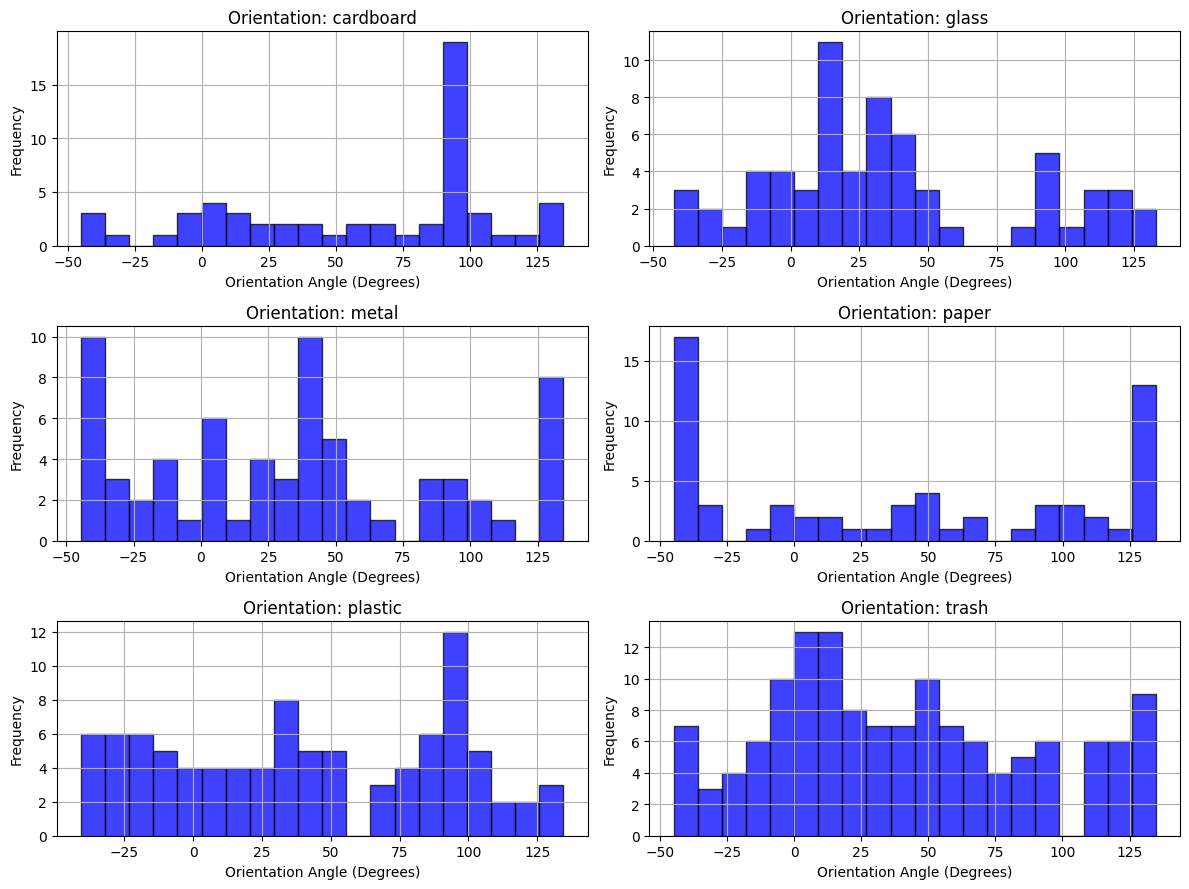

In [10]:
# firstly we will analyze whether rotation is a good idea
# Idea behind : use PCA to find the dominant direction of variance and then plot a histogram of the angles compared to this
# this should be able to be done based on the white background of the images

# we need to redo this because intuitively they are symmetric : e.g. -30 = 330 angle

import itertools
from concurrent.futures import ThreadPoolExecutor

def get_object_orientation(image):
    """
    Extracts the object's principal orientation using PCA on its contour points.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None  # No object found

    largest_contour = max(contours, key=cv2.contourArea)
    points = np.squeeze(largest_contour)  # Remove unnecessary dimension

    if len(points.shape) != 2 or points.shape[0] < 2:  # Avoid errors with tiny/noisy contours
        return None

    pca = PCA(n_components=2).fit(points)  # Fit PCA directly on NumPy array
    angle = np.degrees(np.arctan2(*pca.components_[0][::-1]))  # Compute angle in degrees
    return angle

def process_image(image_path):
    """
    Helper function to process an image and return its orientation.
    Used for parallel execution.
    """
    image = cv2.imread(image_path)
    if image is None:
        return None
    return get_object_orientation(image)

def analyze_orientation_per_class(train_dir):
    """
    Analyzes the orientation of objects for each class in the training dataset.
    Optimized with threading and efficient file access.
    """
    class_folders = [f.path for f in os.scandir(train_dir) if f.is_dir()]

    all_orientations = {}
    
    fig, axes = plt.subplots(3, 2, figsize=(12, 9))
    axes = axes.flatten()

    for idx, class_path in enumerate(class_folders):
        class_name = os.path.basename(class_path)

        # Use itertools.chain to merge jpg & png file search
        image_files = itertools.chain(glob(os.path.join(class_path, "*.jpg")), 
                                      glob(os.path.join(class_path, "*.png")))

        with ThreadPoolExecutor() as executor:
            angles = list(filter(None, executor.map(process_image, image_files)))  # Parallel processing

        all_orientations[class_name] = angles

        if idx < len(axes):
            axes[idx].hist(angles, bins=20, alpha=0.75, color='blue', edgecolor='black')
            axes[idx].set_xlabel("Orientation Angle (Degrees)")
            axes[idx].set_ylabel("Frequency")
            axes[idx].set_title(f"Orientation: {class_name}")
            axes[idx].grid(True)

    # Hide unused subplots if there are fewer than 6 classes
    for idx in range(len(class_folders), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

    return None

analyze_orientation_per_class(path)


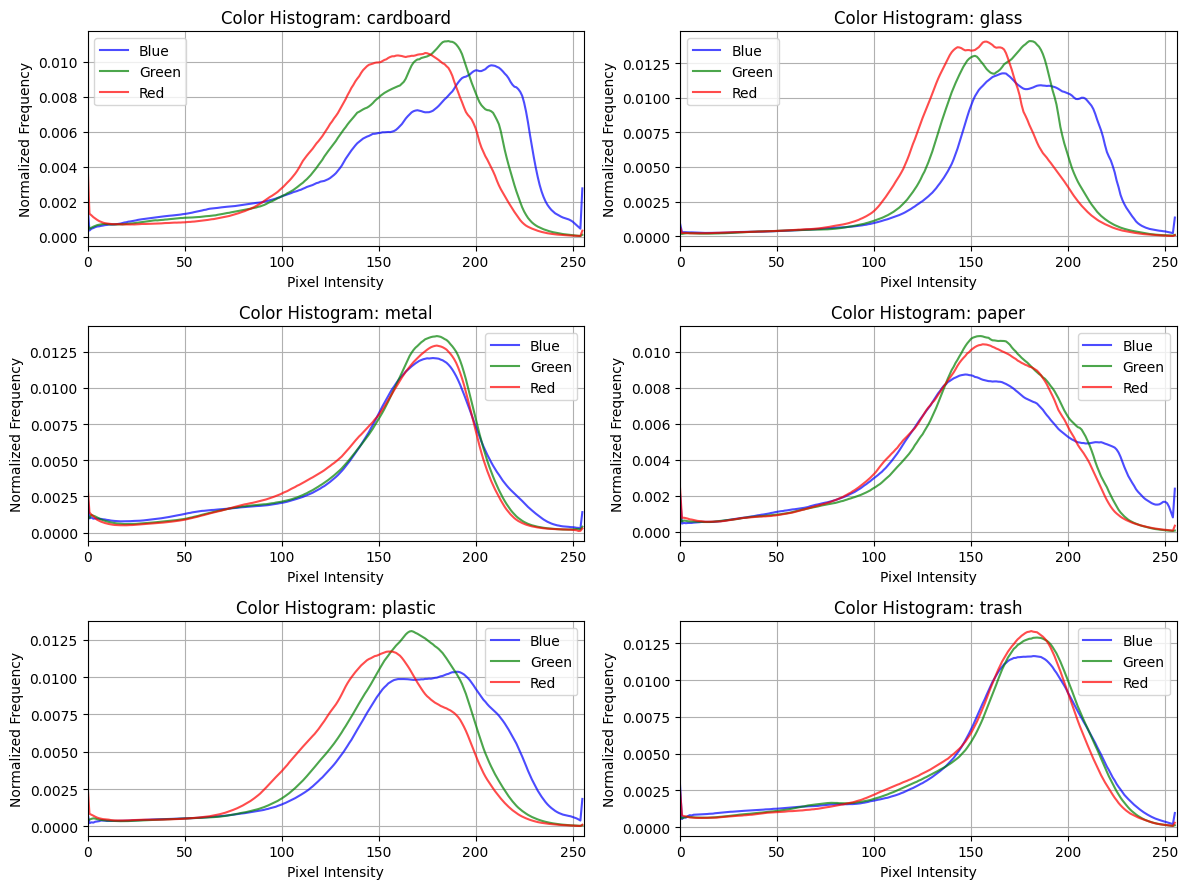

In [11]:
from concurrent.futures import ThreadPoolExecutor

def compute_color_histogram(image):
    """
    Computes the RGB color histogram for an image.
    Returns a dictionary with separate histograms for R, G, B channels.
    """
    # Split channels
    channels = cv2.split(image)
    colors = ('b', 'g', 'r')  # OpenCV uses BGR order
    
    histograms = {}
    for i, color in enumerate(colors):
        hist = cv2.calcHist([channels[i]], [0], None, [256], [0, 256])  # Compute histogram
        hist = hist / hist.sum()  # Normalize histogram
        histograms[color] = hist.flatten()  # Convert to 1D array
    
    return histograms

def process_image_histogram(image_path):
    """
    Reads an image and computes its color histogram.
    """
    image = cv2.imread(image_path)
    if image is None:
        return None
    return compute_color_histogram(image)

def analyze_color_histograms_per_class(train_dir):
    """
    Computes and plots color histograms (RGB) for each class in the training dataset.
    Optimized with multi-threading and efficient file handling.
    """
    class_folders = [f.path for f in os.scandir(train_dir) if f.is_dir()]
    num_classes = len(class_folders)
    
    fig, axes = plt.subplots(3, 2, figsize=(12, 9))
    axes = axes.flatten()
    
    for idx, class_path in enumerate(class_folders):
        class_name = os.path.basename(class_path)

        # Use itertools.chain to merge jpg & png file search
        image_files = itertools.chain(glob(os.path.join(class_path, "*.jpg")), 
                                      glob(os.path.join(class_path, "*.png")))

        color_sums = {'b': np.zeros(256), 'g': np.zeros(256), 'r': np.zeros(256)}
        num_images = 0

        # Process images in parallel
        with ThreadPoolExecutor() as executor:
            results = list(filter(None, executor.map(process_image_histogram, image_files)))

        for histograms in results:
            for color in ('b', 'g', 'r'):
                color_sums[color] += histograms[color]
            num_images += 1

        # Average the histograms
        if num_images > 0:
            for color in color_sums:
                color_sums[color] /= num_images

        # Plot histograms for the class
        if idx < len(axes):
            for color, label in zip(('b', 'g', 'r'), ('Blue', 'Green', 'Red')):
                axes[idx].plot(color_sums[color], color=color, label=label, alpha=0.7)
            
            axes[idx].set_xlim([0, 256])
            axes[idx].set_xlabel("Pixel Intensity")
            axes[idx].set_ylabel("Normalized Frequency")
            axes[idx].set_title(f"Color Histogram: {class_name}")
            axes[idx].legend()
            axes[idx].grid(True)

    # Hide unused subplots if num_classes < 6
    for idx in range(num_classes, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
analyze_color_histograms_per_class(path)


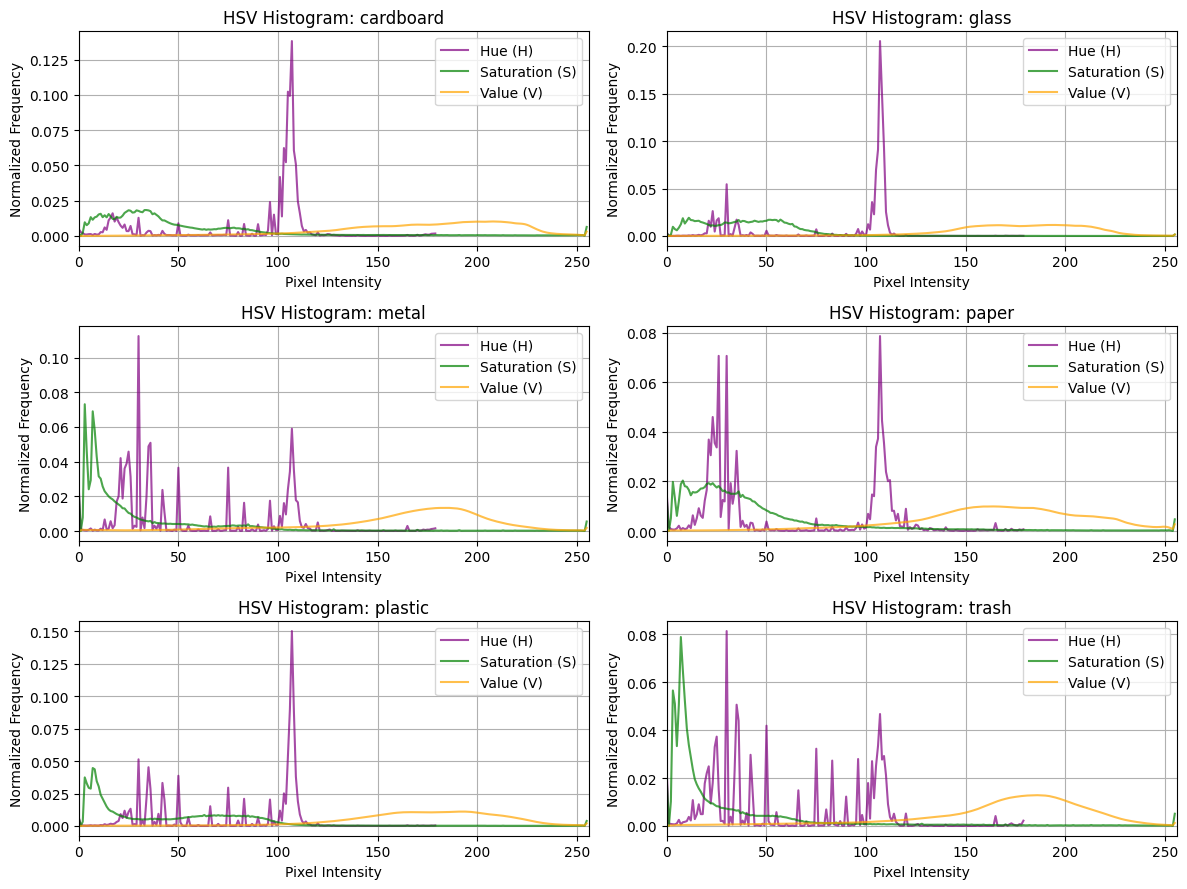

In [12]:
# hsv histograms : HSV (Hue, Saturation, Value) for color space 

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
import itertools
from concurrent.futures import ThreadPoolExecutor

def compute_hsv_histogram(image):
    """
    Computes the HSV color histogram for an image.
    Returns a dictionary with separate histograms for Hue (H), Saturation (S), and Value (V).
    """
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)  # Convert to HSV
    channels = cv2.split(hsv_image)
    histograms = {}

    # Compute histograms for Hue, Saturation, and Value
    histograms['H'] = cv2.calcHist([channels[0]], [0], None, [180], [0, 180])  # Hue (0-180 range)
    histograms['S'] = cv2.calcHist([channels[1]], [0], None, [256], [0, 256])  # Saturation (0-255)
    histograms['V'] = cv2.calcHist([channels[2]], [0], None, [256], [0, 256])  # Value (0-255)

    # Normalize histograms for better comparison
    for key in histograms:
        histograms[key] /= histograms[key].sum()

    return histograms

def process_image_hsv(image_path):
    """
    Reads an image and computes its HSV histogram.
    """
    image = cv2.imread(image_path)
    if image is None:
        return None
    return compute_hsv_histogram(image)

def analyze_hsv_histograms_per_class(train_dir):
    """
    Computes and plots HSV histograms for each class in the dataset.
    Optimized with multi-threading and efficient file handling.
    """
    class_folders = [f.path for f in os.scandir(train_dir) if f.is_dir()]
    num_classes = len(class_folders)

    fig, axes = plt.subplots(3, 2, figsize=(12, 9))
    axes = axes.flatten()

    for idx, class_path in enumerate(class_folders):
        class_name = os.path.basename(class_path)

        # Merge jpg & png file search
        image_files = itertools.chain(glob(os.path.join(class_path, "*.jpg")), 
                                      glob(os.path.join(class_path, "*.png")))

        hsv_sums = {'H': np.zeros(180), 'S': np.zeros(256), 'V': np.zeros(256)}
        num_images = 0

        # Process images in parallel
        with ThreadPoolExecutor() as executor:
            results = list(filter(None, executor.map(process_image_hsv, image_files)))

        for histograms in results:
            for key in hsv_sums:
                hsv_sums[key] += histograms[key].flatten()
            num_images += 1

        # Average the histograms
        if num_images > 0:
            for key in hsv_sums:
                hsv_sums[key] /= num_images

        # Plot histograms for the class
        if idx < len(axes):
            axes[idx].plot(hsv_sums['H'], color='purple', label='Hue (H)', alpha=0.7)
            axes[idx].plot(hsv_sums['S'], color='green', label='Saturation (S)', alpha=0.7)
            axes[idx].plot(hsv_sums['V'], color='orange', label='Value (V)', alpha=0.7)
            
            axes[idx].set_xlim([0, max(len(hsv_sums['H']), len(hsv_sums['S']), len(hsv_sums['V']))])
            axes[idx].set_xlabel("Pixel Intensity")
            axes[idx].set_ylabel("Normalized Frequency")
            axes[idx].set_title(f"HSV Histogram: {class_name}")
            axes[idx].legend()
            axes[idx].grid(True)

    # Hide unused subplots if num_classes < 6
    for idx in range(num_classes, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
analyze_hsv_histograms_per_class(path)  # Change to your actual dataset directory


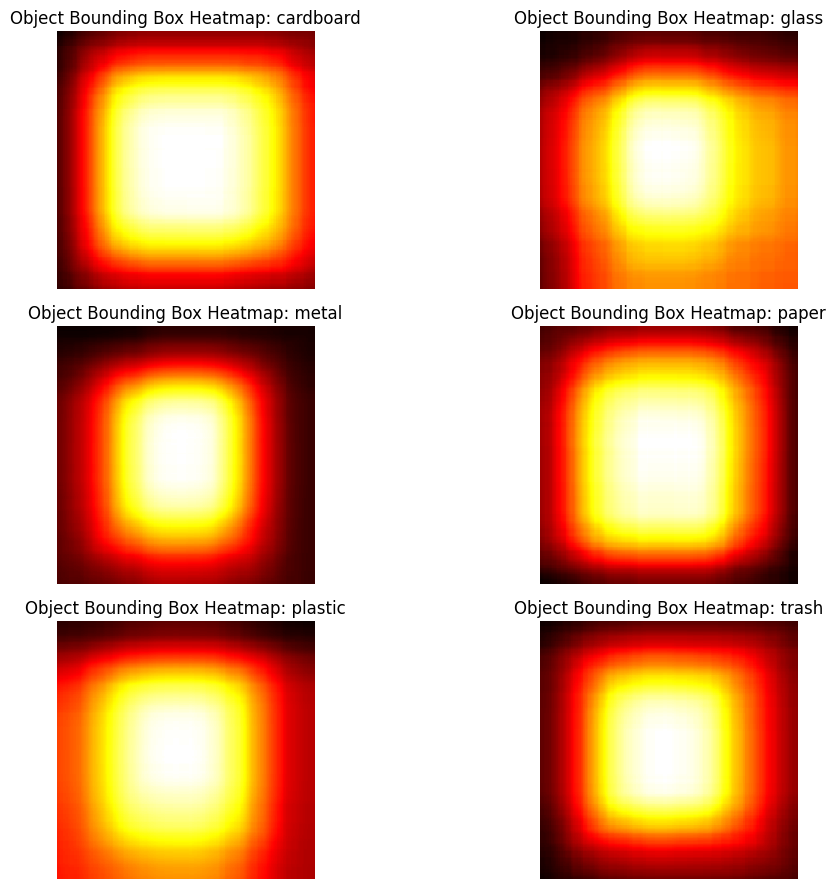

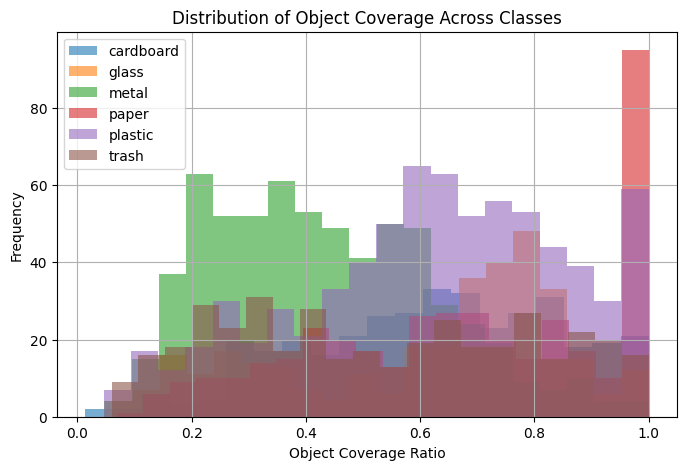

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
from concurrent.futures import ThreadPoolExecutor

def get_bounding_box(image):
    """
    Extracts the bounding box of the foreground object.
    Returns bounding box coordinates and object coverage ratio.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, None

    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)

    object_area = w * h
    image_area = image.shape[0] * image.shape[1]
    coverage_ratio = object_area / image_area

    return (x, y, w, h), coverage_ratio

def process_image_bbox(image_path):
    """
    Reads an image and computes its bounding box and object coverage ratio.
    """
    image = cv2.imread(image_path)
    if image is None:
        return None, None
    return get_bounding_box(image)

def analyze_cropping_potential(train_dir):
    """
    Computes bounding boxes and object coverage per class to determine if cropping is useful.
    """
    class_folders = [f.path for f in os.scandir(train_dir) if f.is_dir()]
    
    fig, axes = plt.subplots(3, 2, figsize=(12, 9))
    axes = axes.flatten()
    
    coverage_ratios = {}

    for idx, class_path in enumerate(class_folders):
        class_name = os.path.basename(class_path)
        
        # Collect all image files
        image_files = glob(os.path.join(class_path, "*.jpg")) + glob(os.path.join(class_path, "*.png"))
        if not image_files:
            continue  # Skip empty folders

        bboxes = []
        coverages = []
        
        # Process images in parallel
        with ThreadPoolExecutor() as executor:
            results = list(filter(lambda x: x[0] is not None, executor.map(process_image_bbox, image_files)))

        for bbox, coverage in results:
            bboxes.append(bbox)
            coverages.append(coverage)

        coverage_ratios[class_name] = coverages

        # Normalize bounding boxes for visualization
        if bboxes:
            img_sample = cv2.imread(image_files[0])
            img_h, img_w = img_sample.shape[:2]  # Get sample image dimensions
            heatmap = np.zeros((img_h, img_w), dtype=np.float32)

            for x, y, w, h in bboxes:
                heatmap[y:y+h, x:x+w] += 1

            heatmap /= heatmap.max()  # Normalize
            axes[idx].imshow(heatmap, cmap="hot", interpolation="nearest")

        axes[idx].set_title(f"Object Bounding Box Heatmap: {class_name}")
        axes[idx].axis("off")

    plt.tight_layout()
    plt.show()

    # Plot object coverage ratios per class
    plt.figure(figsize=(8, 5))
    for class_name, coverages in coverage_ratios.items():
        plt.hist(coverages, bins=20, alpha=0.6, label=class_name)

    plt.xlabel("Object Coverage Ratio")
    plt.ylabel("Frequency")
    plt.title("Distribution of Object Coverage Across Classes")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
analyze_cropping_potential(path)  # Change to your actual dataset directory


C:\Users\vidia\AppData\Local\Temp\ipykernel_38636\1690751690.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(classes, rotation=45, ha="right")
C:\Users\vidia\AppData\Local\Temp\ipykernel_38636\1690751690.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(classes, rotation=45, ha="right")


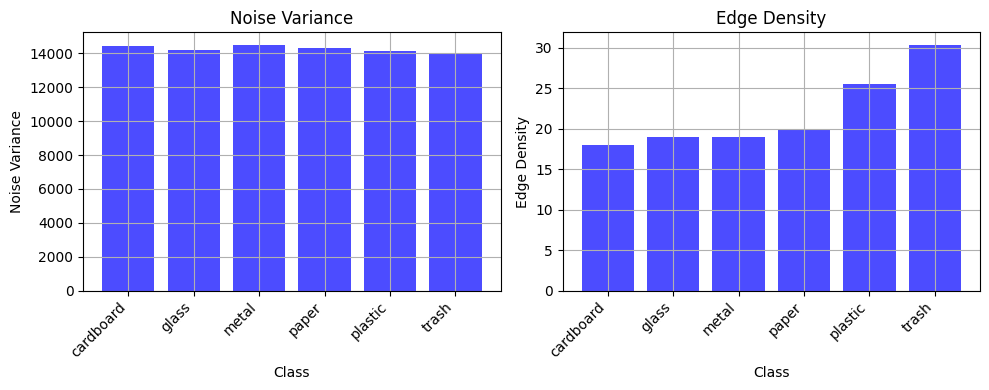

In [14]:
from skimage.metrics import structural_similarity as ssim

def compute_noise_metrics(image):
    """
    Computes noise level using high-frequency filtering, SSIM, edge detection, and SNR.
    Returns noise variance, SSIM, edge count, and signal-to-noise ratio (SNR).
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # **1. Compute Noise Variance (High-Frequency Content)**
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    noise = gray - blurred  # Extract noise
    noise_variance = np.var(noise)

    # **2. Compute Edge Density using Canny Edge Detector**
    edges = cv2.Canny(gray, 100, 200)
    edge_density = np.sum(edges) / (gray.shape[0] * gray.shape[1])  # Edge pixel ratio


    return noise_variance, edge_density

def process_image_noise(image_path):
    """
    Reads an image and computes its noise metrics.
    """
    image = cv2.imread(image_path)
    if image is None:
        return None
    return compute_noise_metrics(image)

def analyze_noise_per_class(train_dir):
    """
    Analyzes noise levels in each class of the dataset using variance, SSIM, edge density, and SNR.
    """
    class_folders = [f.path for f in os.scandir(train_dir) if f.is_dir()]

    noise_data = {}

    for class_path in class_folders:
        class_name = os.path.basename(class_path)

        # Collect image files
        image_files = glob(os.path.join(class_path, "*.jpg")) + glob(os.path.join(class_path, "*.png"))
        if not image_files:
            continue  # Skip empty folders

        noise_variances = []

        edge_densities = []
    

        # Process images in parallel
        with ThreadPoolExecutor() as executor:
            results = list(filter(None, executor.map(process_image_noise, image_files)))

        for noise_var, edge_density in results:
            noise_variances.append(noise_var)
            edge_densities.append(edge_density)
          

        # Store results per class
        noise_data[class_name] = {
            "Noise Variance": np.mean(noise_variances) if noise_variances else 0,
            "Edge Density": np.mean(edge_densities) if edge_densities else 0,
        
        }

    # **Plot Noise Variance, SSIM, Edge Density, and SNR for each class**
    classes = list(noise_data.keys())
    metrics = ["Noise Variance", "Edge Density"]
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes = axes.flatten()

    for idx, metric in enumerate(metrics):
        values = [noise_data[c][metric] for c in classes]
        axes[idx].bar(classes, values, color='blue', alpha=0.7)
        axes[idx].set_title(metric)
        axes[idx].set_xlabel("Class")
        axes[idx].set_ylabel(metric)
        axes[idx].grid(True)
        axes[idx].set_xticklabels(classes, rotation=45, ha="right")

    plt.tight_layout()
    plt.show()

# Example usage:
analyze_noise_per_class(path)  # Change to your dataset directory


c:\Users\vidia\anaconda3\envs\mlp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\vidia\anaconda3\envs\mlp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


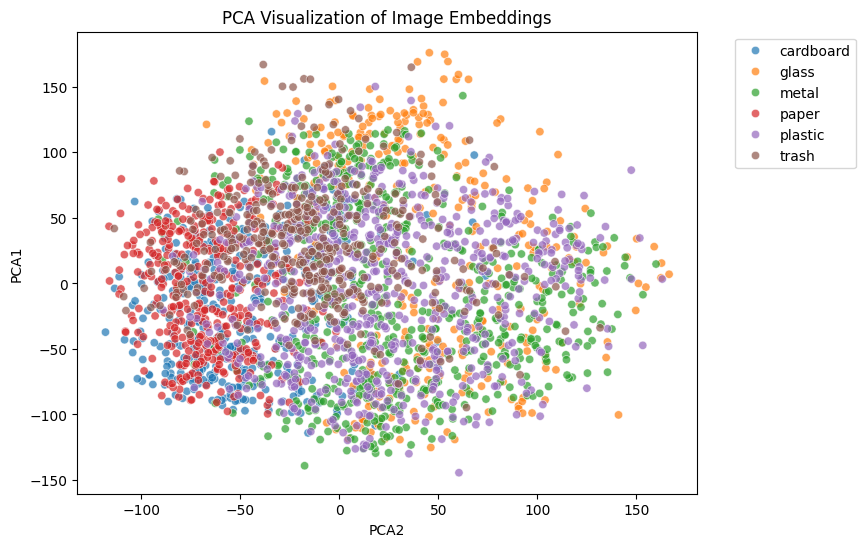

In [15]:
# Use embeddings and PCA - my idea but idk if it will work - this will also be computationally expensive 
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.manifold import TSNE
from glob import glob
import pandas as pd

# ---------------------- 1. Dataset Class ----------------------
class ImageDataset(Dataset):
    """
    Custom dataset class to load images and apply transformations.
    """
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from OpenCV BGR to RGB
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

# ---------------------- 2. Load Image Paths and Labels ----------------------
def load_image_paths_labels(train_dir):
    """
    Loads image paths and their corresponding labels (class names).
    """
    class_folders = [f.path for f in os.scandir(train_dir) if f.is_dir()]

    image_paths = []
    labels = []

    for class_path in class_folders:
        class_name = os.path.basename(class_path)
        class_images = glob(os.path.join(class_path, "*.jpg")) + glob(os.path.join(class_path, "*.png"))

        image_paths.extend(class_images)
        labels.extend([class_name] * len(class_images))

    return image_paths, labels

# Set dataset path (modify this to match your dataset location)
image_paths, labels = load_image_paths_labels(path)

# ---------------------- 3. Define Image Transformations ----------------------
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization
])

# Create dataset and dataloader
dataset = ImageDataset(image_paths, labels, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# ---------------------- 4. Load Pre-trained ResNet-18 Model ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.densenet121(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove the classification layer
model = model.to(device)
model.eval()

# ---------------------- 5. Extract Features ----------------------
features = []
image_labels = []

with torch.no_grad():
    for images, batch_labels in dataloader:
        images = images.to(device)
        outputs = model(images)
        outputs = outputs.view(outputs.size(0), -1)  # Flatten feature maps
        features.append(outputs.cpu().numpy())
        image_labels.extend(batch_labels)

# Convert features to NumPy array
features = np.vstack(features)
#print(features.shape)
#print(features[0])
#print("Sample labels:", image_labels[:10])
      
# ---------------------- 6. Apply t-SNE for Dimensionality Reduction ----------------------
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Apply PCA first to reduce 512 → 50 dimensions
pca = PCA(n_components=2, random_state=42)
features_pca = pca.fit_transform(features)

df_pca = pd.DataFrame(features_pca, columns=['PCA1', 'PCA2'])
df_pca['label'] = image_labels
# ---------------------- 7. Plot t-SNE Results ----------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(x="PCA2", y="PCA1", hue="label", data=df_pca, palette="tab10", alpha=0.7)
plt.title("PCA Visualization of Image Embeddings")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [19]:
#pip install openTSNE -> you might need to install this or add to requirements.txt
# experiment with tsne as well better than PCA 

C:\Users\vidia\AppData\Roaming\Python\Python312\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


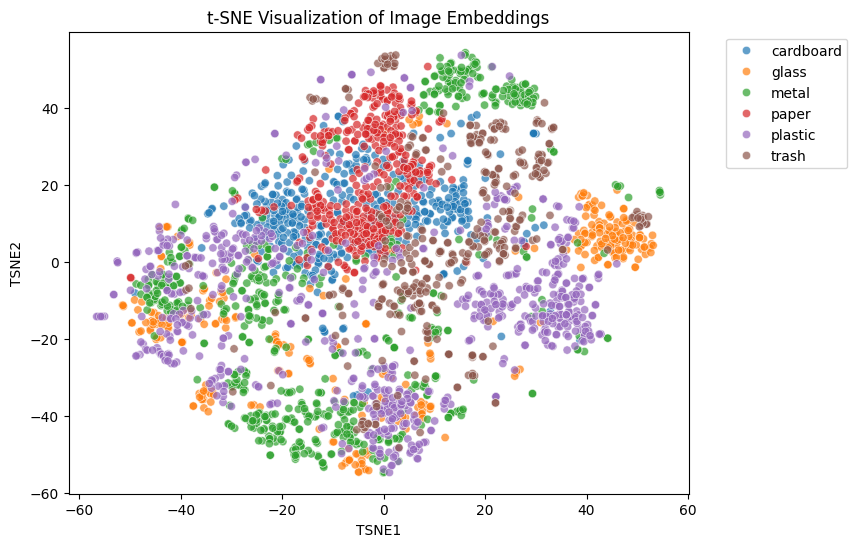

In [16]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.manifold import TSNE
from glob import glob
import pandas as pd

# ---------------------- 1. Dataset Class ----------------------
class ImageDataset(Dataset):
    """
    Custom dataset class to load images and apply transformations.
    """
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from OpenCV BGR to RGB
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

# ---------------------- 2. Load Image Paths and Labels ----------------------
def load_image_paths_labels(train_dir):
    """
    Loads image paths and their corresponding labels (class names).
    """
    class_folders = [f.path for f in os.scandir(train_dir) if f.is_dir()]

    image_paths = []
    labels = []

    for class_path in class_folders:
        class_name = os.path.basename(class_path)
        class_images = glob(os.path.join(class_path, "*.jpg")) + glob(os.path.join(class_path, "*.png"))

        image_paths.extend(class_images)
        labels.extend([class_name] * len(class_images))

    return image_paths, labels

# Set dataset path
path = "../data/dataset_split/train"  # Update with your dataset path
image_paths, labels = load_image_paths_labels(path)

# ---------------------- 3. Define Image Transformations ----------------------
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization
])

# Create dataset and dataloader
dataset = ImageDataset(image_paths, labels, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# ---------------------- 4. Load Pre-trained DenseNet-121 Model ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove the classification layer
model = model.to(device)
model.eval()

# ---------------------- 5. Extract Features ----------------------
features = []
image_labels = []

with torch.no_grad():
    for images, batch_labels in dataloader:
        images = images.to(device)
        outputs = model(images)
        outputs = outputs.view(outputs.size(0), -1)  # Flatten feature maps
        features.append(outputs.cpu().numpy())
        image_labels.extend(batch_labels)

# Convert features to NumPy array
features = np.vstack(features)

# ---------------------- 6. Apply t-SNE for Dimensionality Reduction ----------------------
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
features_tsne = tsne.fit_transform(features)

# ---------------------- 7. Prepare Data for Visualization ----------------------
df_tsne = pd.DataFrame(features_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['label'] = image_labels

# ---------------------- 8. Plot t-SNE Results ----------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(x="TSNE1", y="TSNE2", hue="label", data=df_tsne, palette="tab10", alpha=0.7)
plt.title("t-SNE Visualization of Image Embeddings")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
